# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *
from modules.data_import import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam', 'do':0.3}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [5]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"))

def reconvert_event(in_data):
    move_to_cartesian(in_data, 'PRI_tau', drop=False)
    move_to_cartesian(in_data, 'PRI_lep', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_leading', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_subleading', drop=False)
    move_to_cartesian(in_data, 'PRI_met', z=False)

id = 19
nom = pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]

z_flip = nom.copy()
z_flip_event(z_flip)
reconvert_event(z_flip)

rot = nom.copy()
rotate_event(rot)
reconvert_event(rot)

rot_y = nom.copy()
rotate_event(rot_y)
y_flip_event(rot_y)
reconvert_event(rot_y)

rot_yz = nom.copy()
rotate_event(rot_yz)
y_flip_event(rot_yz)
z_flip_event(rot_yz)
reconvert_event(rot_yz)

comp_events([nom, rot, rot_y, rot_yz])

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


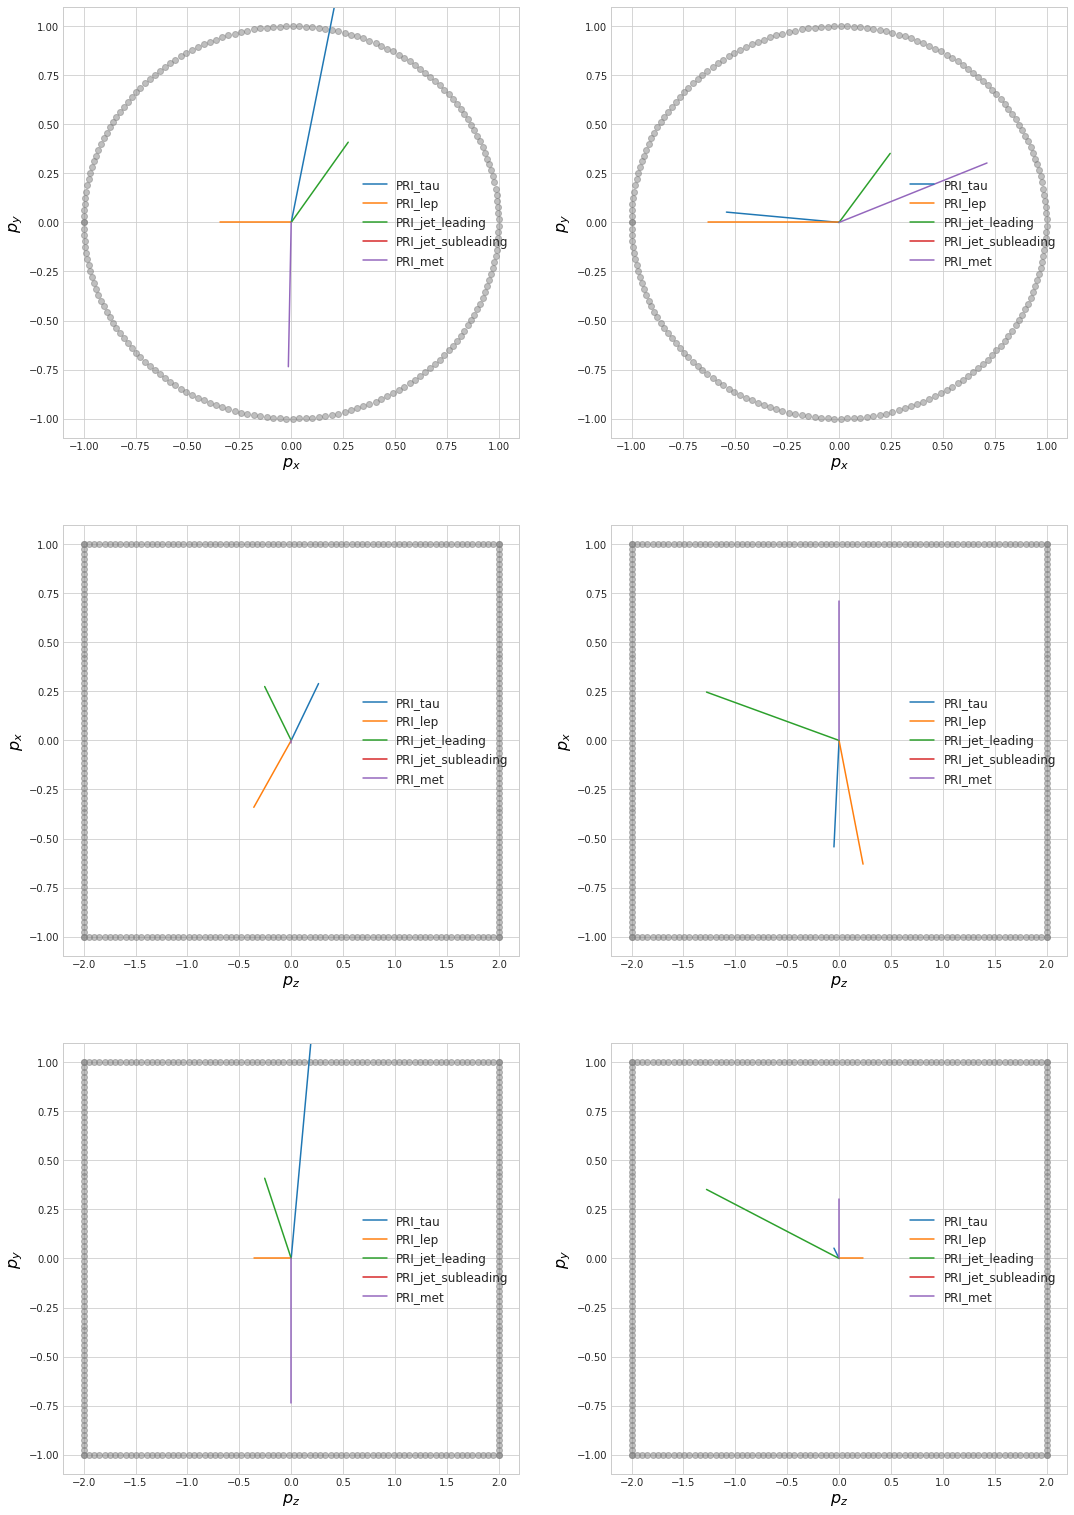

In [6]:
id = 0
pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]
comp_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1],
             pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id+1:id+2]])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 22.711s 


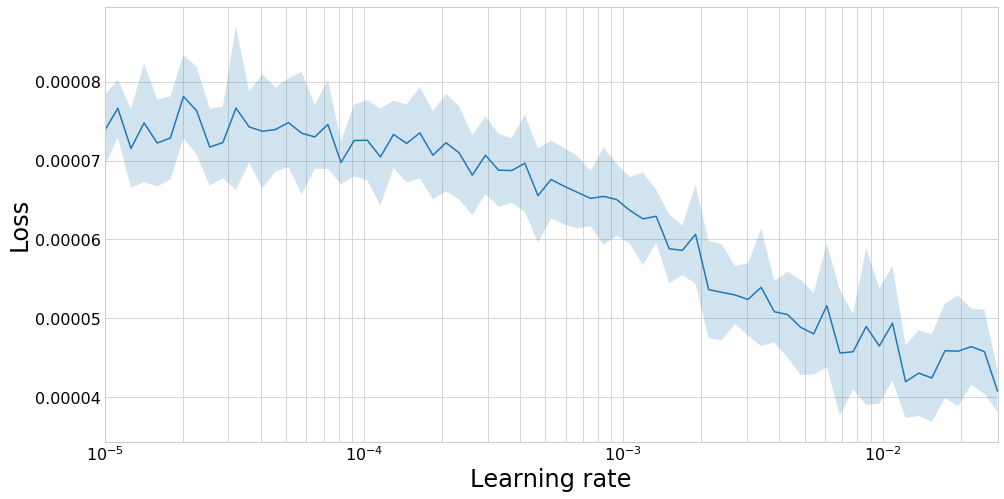

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [11]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':8e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

In [12]:
model_gen_params

{'version': 'modelSwish',
 'n_in': 30,
 'compile_args': {'loss': 'binary_crossentropy',
  'optimizer': 'adam',
  'do': 0.3,
  'lr': 0.008,
  'amsgrad': False,
  'beta_1': 0.9},
 'mode': 'classifier'}

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.377200). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189030). Check your callbacks.
  % delta_t_median)


1 New best found: 3.655562685820729e-05
2 New best found: 3.529794074330693e-05
3 New best found: 3.446572540878363e-05
5 New best found: 3.430892247930399e-05
6 New best found: 3.3676677065978716e-05
13 New best found: 3.3246715803152753e-05
14 New best found: 3.321278092984463e-05
15 New best found: 3.3164692387113575e-05
25 New best found: 3.2941978639271646e-05
26 New best found: 3.28443355776869e-05
27 New best found: 3.2760337461876095e-05
29 New best found: 3.2658439599348844e-05
30 New best found: 3.2610794717947254e-05
31 New best found: 3.2609873169837127e-05
52 New best found: 3.2513513187851e-05
55 New best found: 3.250963925076444e-05
56 New best found: 3.247175748760728e-05
57 New best found: 3.235478392539972e-05
60 New best found: 3.234390069860209e-05
61 New best found: 3.233692347254712e-05
62 New best found: 3.2336286897927646e-05
63 New best found: 3.233355596697734e-05
118 New best found: 3.2317520582440066e-05
210 New best found: 3.2316687421898295e-05
222 New bes

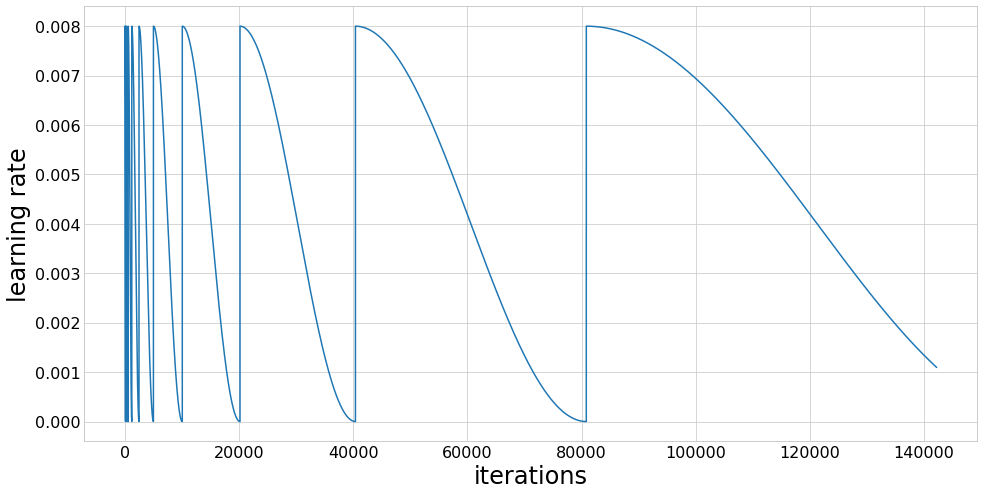

Fold took 2095.654s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.418507). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209670). Check your callbacks.
  % delta_t_median)


1 New best found: 3.629192319747063e-05
2 New best found: 3.589787765313794e-05
3 New best found: 3.4499242557088065e-05
6 New best found: 3.367608720625588e-05
7 New best found: 3.351442187720058e-05
10 New best found: 3.341785302998315e-05
13 New best found: 3.302849834342503e-05
14 New best found: 3.2710027283913244e-05
15 New best found: 3.267378530663936e-05
26 New best found: 3.252275321313731e-05
28 New best found: 3.250072361281475e-05
29 New best found: 3.242238587798633e-05
30 New best found: 3.238788407388082e-05
31 New best found: 3.2381064360752846e-05
54 New best found: 3.2207581400041275e-05
57 New best found: 3.21869635633129e-05
58 New best found: 3.2104065895930425e-05
59 New best found: 3.208946362436181e-05
CosineAnneal stalling after 127 epochs, entering redux decay at LR=0.000306387008900443
129 New best found: 3.2089166693508325e-05
131 New best found: 3.205433016393109e-05
Early stopping after 141 epochs
Score is: {'loss': 3.205433016393109e-05, 'wAUC': 0.064271

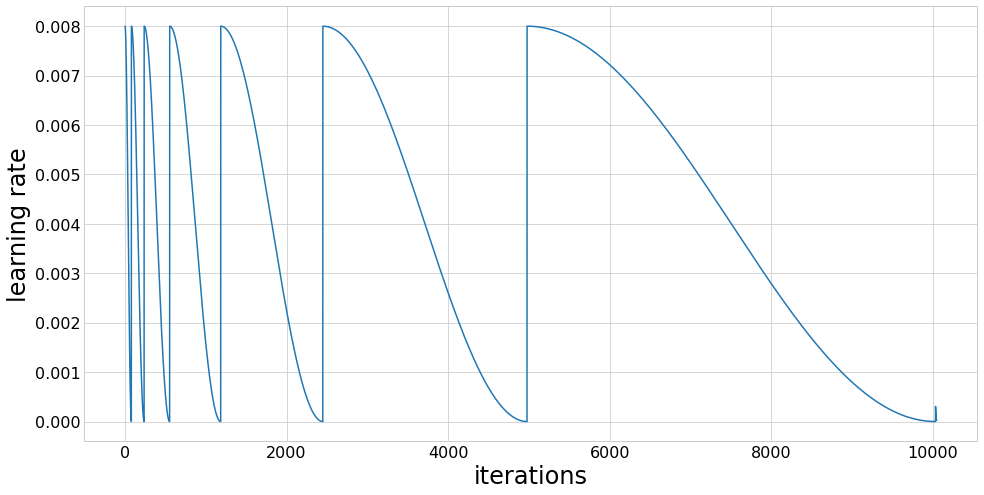

Fold took 172.487s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.468766). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.234755). Check your callbacks.
  % delta_t_median)


1 New best found: 3.565921992558288e-05
2 New best found: 3.409699573385296e-05
3 New best found: 3.359206022578292e-05
6 New best found: 3.2781578339927364e-05
7 New best found: 3.253424345020903e-05
13 New best found: 3.197965802100953e-05
14 New best found: 3.193395562266232e-05
27 New best found: 3.188127112662187e-05
28 New best found: 3.1732709050993437e-05
29 New best found: 3.1701246291049757e-05
30 New best found: 3.169439745106501e-05
31 New best found: 3.1688012994709427e-05
53 New best found: 3.159080231707776e-05
58 New best found: 3.155664362420793e-05
59 New best found: 3.154436443001032e-05
109 New best found: 3.153813329990953e-05
CosineAnneal stalling after 255 epochs, entering redux decay at LR=0.0014643486915939218
256 New best found: 3.15286464363453e-05
Early stopping after 266 epochs
Score is: {'loss': 3.15286464363453e-05, 'wAUC': 0.061775323597176635, 'AUC': 0.09896050367313669, 'AMS': 4.038994223737961, 'cut': 0.9647295475006104}


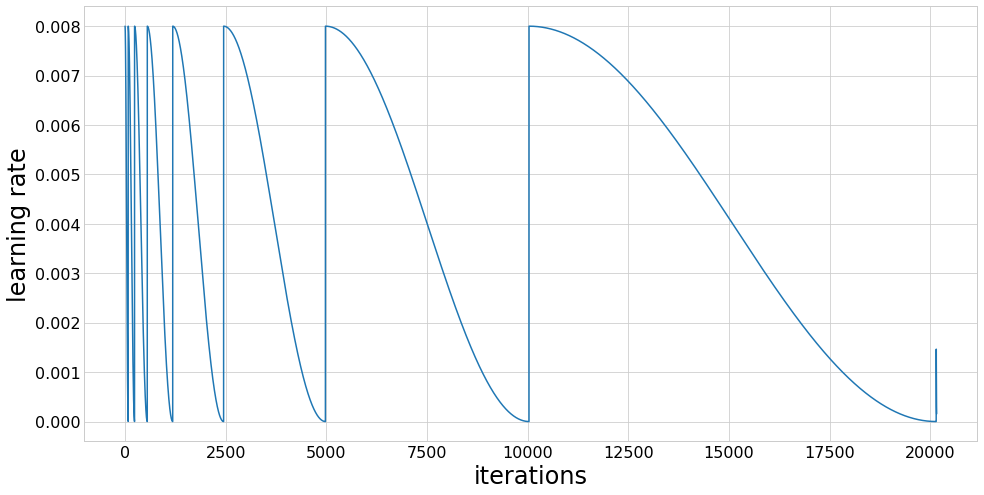

Fold took 324.233s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.537627). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.269331). Check your callbacks.
  % delta_t_median)


1 New best found: 3.6868696262365186e-05
2 New best found: 3.509325590489079e-05
3 New best found: 3.452951063065665e-05
5 New best found: 3.3956348976450335e-05
6 New best found: 3.345091562754043e-05
7 New best found: 3.333080794640865e-05
11 New best found: 3.3306073191977255e-05
12 New best found: 3.318681442189453e-05
13 New best found: 3.290345449762818e-05
14 New best found: 3.283387319895006e-05
15 New best found: 3.279058548032559e-05
26 New best found: 3.270744929772344e-05
27 New best found: 3.261358724068462e-05
28 New best found: 3.2499165589454544e-05
30 New best found: 3.249294873544183e-05
31 New best found: 3.2489918842909596e-05
55 New best found: 3.2439598218454264e-05
57 New best found: 3.239460213043092e-05
58 New best found: 3.23504495040376e-05
61 New best found: 3.233486874733764e-05
CosineAnneal stalling after 127 epochs, entering redux decay at LR=7.783168068201883e-05
130 New best found: 3.233143181429216e-05
134 New best found: 3.23283096943858e-05
Early sto

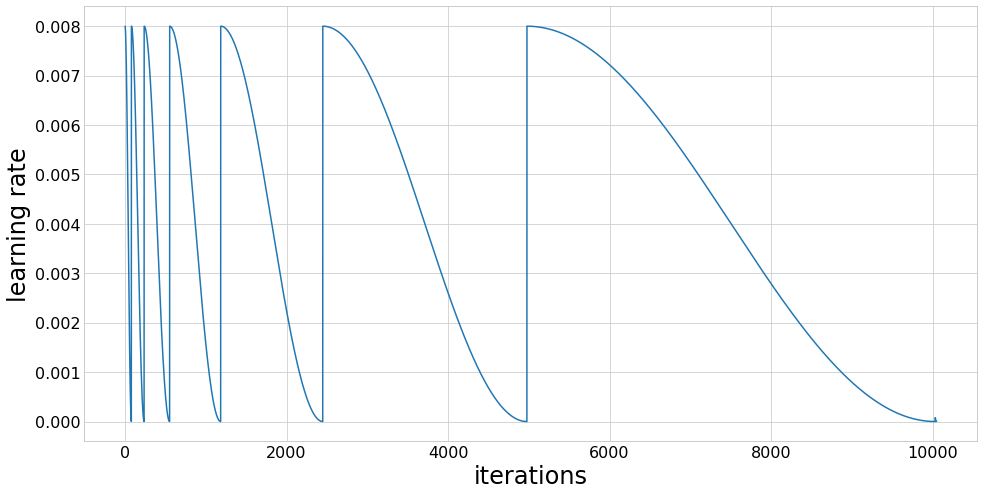

Fold took 180.834s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.537618). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.269196). Check your callbacks.
  % delta_t_median)


1 New best found: 3.596417217195267e-05
2 New best found: 3.48236186298891e-05
3 New best found: 3.424406109261327e-05
4 New best found: 3.419861920701806e-05
5 New best found: 3.334236701775808e-05
7 New best found: 3.3111251938680654e-05
10 New best found: 3.293844920117408e-05
12 New best found: 3.278593518771231e-05
13 New best found: 3.2371330723981376e-05
14 New best found: 3.23277439631056e-05
15 New best found: 3.2316915641422384e-05
25 New best found: 3.2278553667129015e-05
28 New best found: 3.2038238285167606e-05
30 New best found: 3.197336316516157e-05
31 New best found: 3.196728530165274e-05
56 New best found: 3.189598974568071e-05
58 New best found: 3.186641612264793e-05
60 New best found: 3.1822788825957104e-05
61 New best found: 3.1814698869129645e-05
114 New best found: 3.181338492431678e-05
229 New best found: 3.1780644608079456e-05
418 New best found: 3.1762851662642785e-05
420 New best found: 3.175120653613703e-05
425 New best found: 3.1648537347791716e-05
438 New b

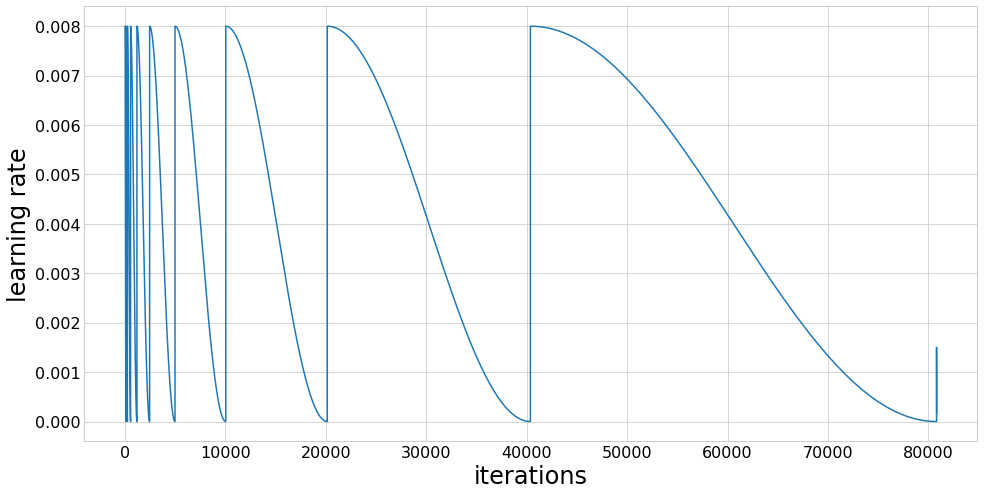

Fold took 1277.551s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.565441). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.283210). Check your callbacks.
  % delta_t_median)


1 New best found: 3.605722729521738e-05
2 New best found: 3.464456504997802e-05
3 New best found: 3.4043717526860816e-05
5 New best found: 3.3617063808388085e-05
6 New best found: 3.319036886519176e-05
7 New best found: 3.3017960976271464e-05
12 New best found: 3.291203255739149e-05
13 New best found: 3.282485603281995e-05
14 New best found: 3.262824242483464e-05
15 New best found: 3.260246002904641e-05
25 New best found: 3.2398766792868286e-05
26 New best found: 3.2288072409385386e-05
29 New best found: 3.217845217243024e-05
30 New best found: 3.2151199044308106e-05
31 New best found: 3.214961193297688e-05
60 New best found: 3.21151770222554e-05
61 New best found: 3.210794767752928e-05
62 New best found: 3.2104318841025484e-05
63 New best found: 3.2103765322786096e-05
119 New best found: 3.200763668015154e-05
218 New best found: 3.1994319542811454e-05
223 New best found: 3.196737083317358e-05
225 New best found: 3.190664415241189e-05
236 New best found: 3.188660882790885e-05
423 New b

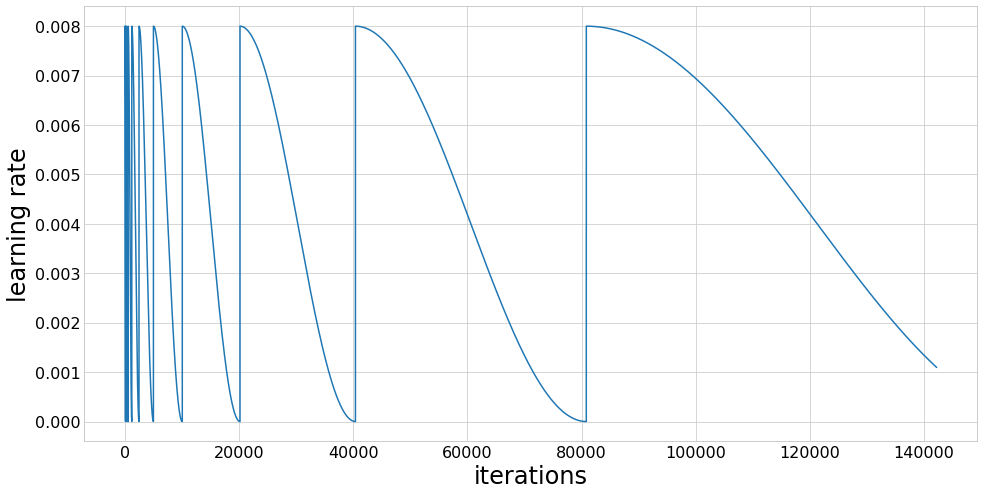

Fold took 2252.753s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.608614). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.304774). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7344349850900474e-05
2 New best found: 3.573832684342051e-05
3 New best found: 3.468097872901126e-05
4 New best found: 3.447928458335809e-05
6 New best found: 3.390707270882558e-05
7 New best found: 3.3713520759920355e-05
12 New best found: 3.3416863239108355e-05
13 New best found: 3.3103866957389984e-05
14 New best found: 3.301050740192295e-05
15 New best found: 3.2951323975430566e-05
25 New best found: 3.270677885011537e-05
28 New best found: 3.246512921105023e-05
29 New best found: 3.2445927998924164e-05
31 New best found: 3.244219539046753e-05
54 New best found: 3.240492055847426e-05
57 New best found: 3.224678563710768e-05
60 New best found: 3.221296005503973e-05
116 New best found: 3.219486606030841e-05
118 New best found: 3.209490467852447e-05
CosineAnneal stalling after 255 epochs, entering redux decay at LR=0.000385106205112469
Early stopping after 265 epochs
Score is: {'loss': 3.209490467852447e-05, 'wAUC': 0.06420124250496828, 'AUC': 0.09987822144693914, 

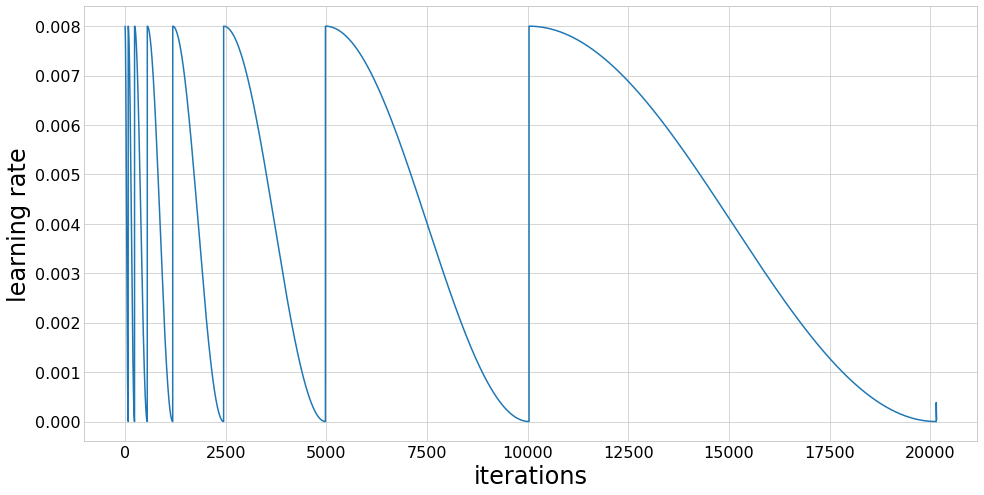

Fold took 340.888s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.645293). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.323147). Check your callbacks.
  % delta_t_median)


1 New best found: 3.586109192176297e-05
2 New best found: 3.5347827405837535e-05
3 New best found: 3.43949482472665e-05
5 New best found: 3.425854490080978e-05
6 New best found: 3.3493508157031386e-05
7 New best found: 3.3475275621786334e-05
12 New best found: 3.3420566671354116e-05
13 New best found: 3.318742384088141e-05
14 New best found: 3.30250842464858e-05
15 New best found: 3.298359249347539e-05
24 New best found: 3.292989022487729e-05
25 New best found: 3.278912925196086e-05
28 New best found: 3.272500708547752e-05
29 New best found: 3.262844359377925e-05
30 New best found: 3.262654697701803e-05
31 New best found: 3.2626193585260034e-05
55 New best found: 3.260031723778538e-05
56 New best found: 3.257271196816613e-05
59 New best found: 3.2567448338130146e-05
60 New best found: 3.254158388922986e-05
61 New best found: 3.252454591741187e-05
62 New best found: 3.252427157120667e-05
109 New best found: 3.251939299476699e-05
116 New best found: 3.2506842555182094e-05
119 New best fo

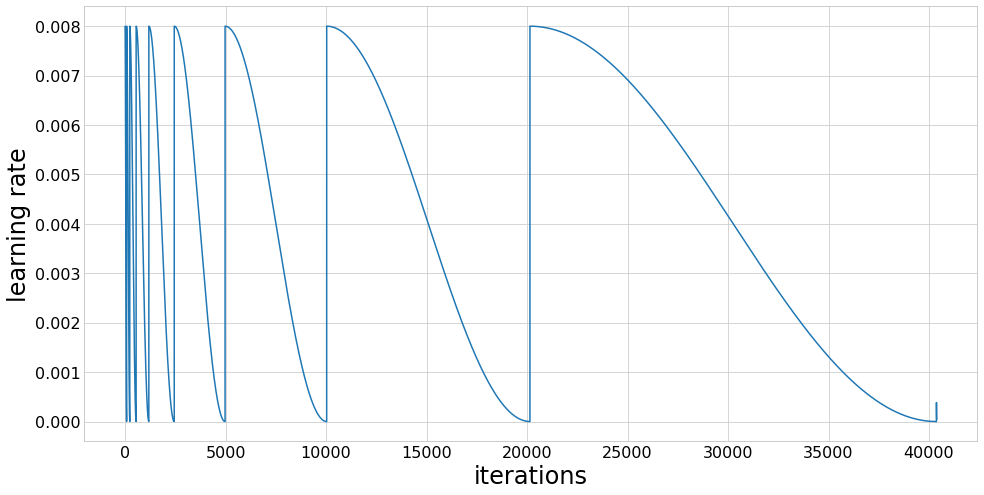

Fold took 666.544s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.698657). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.349830). Check your callbacks.
  % delta_t_median)


1 New best found: 3.611256709700683e-05
2 New best found: 3.539690095785772e-05
3 New best found: 3.408884506206959e-05
6 New best found: 3.351685812958749e-05
7 New best found: 3.3305617718724534e-05
12 New best found: 3.308315578324255e-05
13 New best found: 3.289096945227356e-05
14 New best found: 3.265560646541417e-05
15 New best found: 3.262327138218097e-05
29 New best found: 3.251797017583158e-05
30 New best found: 3.2475845752924214e-05
52 New best found: 3.2390692734043116e-05
58 New best found: 3.233557933708653e-05
59 New best found: 3.2333439211652145e-05
110 New best found: 3.230127826100215e-05
117 New best found: 3.225185996125219e-05
200 New best found: 3.22271552082384e-05
203 New best found: 3.217542959173443e-05
231 New best found: 3.216865736903856e-05
234 New best found: 3.211643434042344e-05
237 New best found: 3.210543254826917e-05
450 New best found: 3.2088522468984595e-05
455 New best found: 3.2072860094194766e-05
457 New best found: 3.20339477431844e-05
466 New

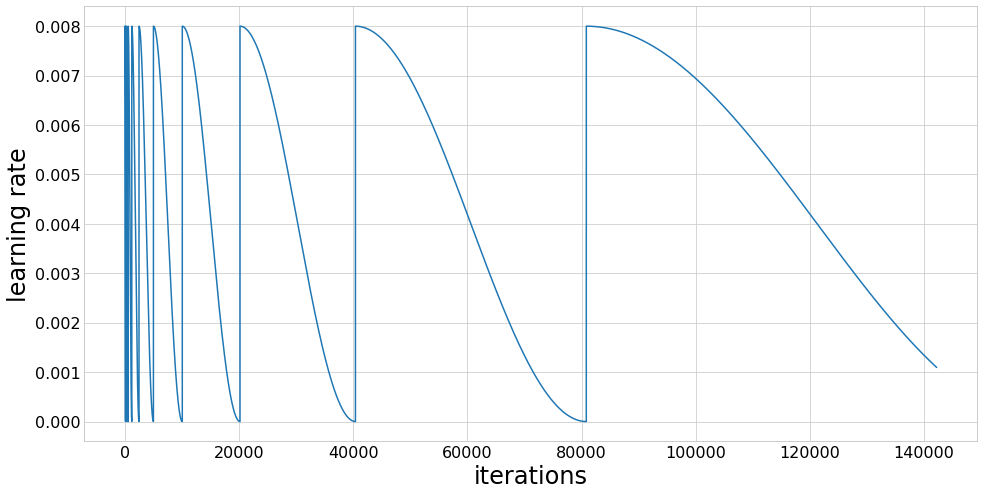

Fold took 2305.751s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.704385). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.352708). Check your callbacks.
  % delta_t_median)


1 New best found: 3.604801023304432e-05
2 New best found: 3.593850421926954e-05
3 New best found: 3.4422061793302134e-05
6 New best found: 3.359361716796662e-05
7 New best found: 3.352578742138122e-05
11 New best found: 3.34839502211531e-05
12 New best found: 3.316744212808241e-05
13 New best found: 3.299831852131825e-05
14 New best found: 3.2930716890956895e-05
15 New best found: 3.2862212908967554e-05
26 New best found: 3.262965349810799e-05
27 New best found: 3.236630683753519e-05
57 New best found: 3.2304122132969056e-05
58 New best found: 3.221252553486855e-05
59 New best found: 3.216910752115722e-05
62 New best found: 3.215680619233902e-05
63 New best found: 3.215582523915833e-05
119 New best found: 3.209717707301982e-05
225 New best found: 3.204642867326379e-05
239 New best found: 3.203774598661039e-05
245 New best found: 3.2030399398471717e-05
461 New best found: 3.2010623657193874e-05
462 New best found: 3.200616647392047e-05
465 New best found: 3.197674004138634e-05
470 New b

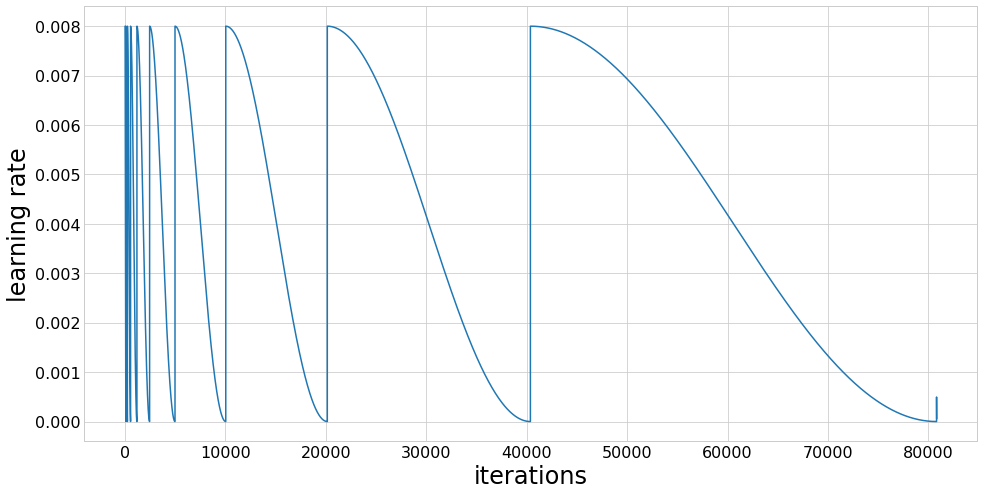

Fold took 1348.438s


______________________________________
Training finished
Cross-validation took 10970.262s 


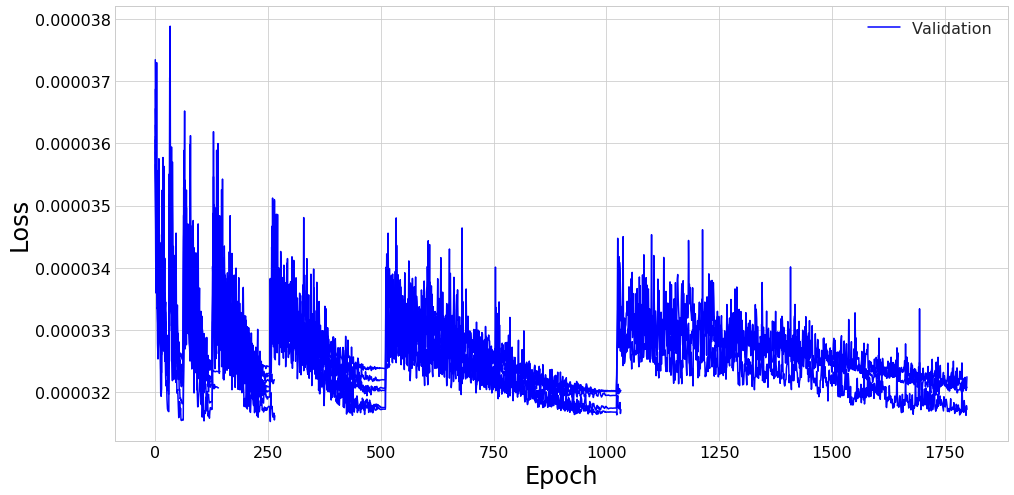

Mean loss = 3.194e-05 +- 8e-08
Mean wAUC = 0.0637 +- 0.0003
Mean AUC = 0.1018 +- 0.0007
Mean AMS = 3.84 +- 0.07
Mean cut = 0.95 +- 0.005
______________________________________



<Figure size 432x288 with 0 Axes>

In [13]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [14]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [15]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 2 with loss = 3.15286464363453e-05
Model 1 is 5 with loss = 3.16280711241672e-05
Model 2 is 4 with loss = 3.1628639562404714e-05
Model 3 is 8 with loss = 3.191492756741354e-05
Model 4 is 9 with loss = 3.194373878314885e-05
Model 5 is 0 with loss = 3.195270537103599e-05
Model 6 is 1 with loss = 3.205433016393109e-05
Model 7 is 6 with loss = 3.209490467852447e-05
Model 8 is 7 with loss = 3.232263741273638e-05
Model 9 is 3 with loss = 3.23283096943858e-05


## Response on validation data without TTA

In [16]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [17]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0026728168196976185s per sample

Predicting fold 2 out of 10
Prediction took 0.00039971446096897123s per sample

Predicting fold 3 out of 10
Prediction took 0.00040123465284705163s per sample

Predicting fold 4 out of 10
Prediction took 0.0004030051752924919s per sample

Predicting fold 5 out of 10
Prediction took 0.0004168233767151833s per sample

Predicting fold 6 out of 10
Prediction took 0.000398514936119318s per sample

Predicting fold 7 out of 10
Prediction took 0.0004080006040632725s per sample

Predicting fold 8 out of 10
Prediction took 0.00040692892000079156s per sample

Predicting fold 9 out of 10
Prediction took 0.0004072396673262119s per sample

Predicting fold 10 out of 10
Prediction took 0.00040570668652653694s per sample



In [18]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [19]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.8997914694494827, weighted 0.9352407883929212


Best cut at 0.9408638143205309 corresponds to AMS of 3.748959775942414
Maximum AMS for data is 3.784223597452546 at cut of 0.934147834777832
CPU times: user 27.3 s, sys: 0 ns, total: 27.3 s
Wall time: 27.3 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


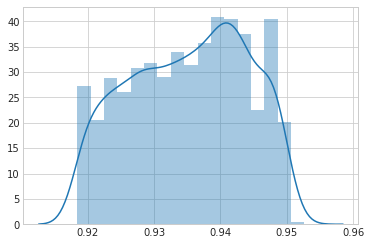

In [20]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.9351652 corresponds to AMS of 3.770841183719802
Maximum AMS for data is 3.784223597452546 at cut of 0.934147834777832
CPU times: user 101 ms, sys: 0 ns, total: 101 ms
Wall time: 99.3 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


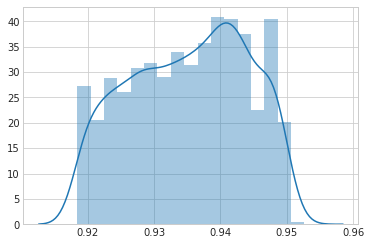

In [21]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [22]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [23]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00039974840141155505s per sample

Predicting fold 2 out of 10
Prediction took 0.0003985316248779947s per sample

Predicting fold 3 out of 10
Prediction took 0.00039873468496582726s per sample

Predicting fold 4 out of 10
Prediction took 0.0003945978969335556s per sample

Predicting fold 5 out of 10
Prediction took 0.0004010482635010373s per sample

Predicting fold 6 out of 10
Prediction took 0.00040316668010570786s per sample

Predicting fold 7 out of 10
Prediction took 0.0004011341709982265s per sample

Predicting fold 8 out of 10
Prediction took 0.0003976089096204801s per sample

Predicting fold 9 out of 10
Prediction took 0.00039958621927283026s per sample

Predicting fold 10 out of 10
Prediction took 0.0003992827806960453s per sample

CPU times: user 4min 20s, sys: 23.6 s, total: 4min 43s
Wall time: 3min 39s


In [24]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.693140967837202 : 3.6781371323462313


(3.693140967837202, 3.6781371323462313)

In [25]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.7016151651647227 : 3.6765678873928382


(3.7016151651647227, 3.6765678873928382)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)